<a href="https://colab.research.google.com/github/JEN6YT/APS360/blob/main/Jennifer_Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1e3g3GxiuXf3CuH4SyUYhdLEsryb_Z-_y#scrollTo=LfiFE_WOqIDu 

In [7]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [8]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

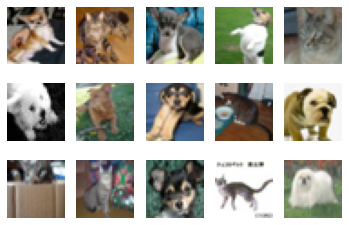

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
count_cat_train = 0
count_dog_train = 0

count_cat_val = 0
count_dog_val = 0

count_cat_test = 0
count_dog_test = 0

for images, labels in train_loader:
  for label in labels:
    if label == 3: # corresponding to 'cats'
      count_cat_train += 1
    elif label == 5: # corresponding to 'dogs'
      count_dog_train += 1

for images, labels in val_loader:
  for label in labels:
    if label == 3: # corresponding to 'cats'
      count_cat_val += 1
    elif label == 5: # corresponding to 'dogs'
      count_dog_val += 1

for images, labels in test_loader:
  for label in labels:
    if label == 3: # corresponding to 'cats'
      count_cat_test += 1
    elif label == 5: # corresponding to 'dogs'
      count_dog_test += 1

print("Cat Train Count:", count_cat_train)
print("Dog Train Count:", count_dog_train)

print("Cat Validation Count:", count_cat_val)
print("Dog Validation Count:", count_dog_val)

print("Cat Testing Count:", count_dog_test)
print("Dog Testing Count:", count_cat_test)

Cat Train Count: 4018
Dog Train Count: 3982
Cat Validation Count: 982
Dog Validation Count: 1018
Cat Testing Count: 1000
Dog Testing Count: 1000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
# We need validation set to validate our training result to make sure that the model works on data that it has not seen before.
# If we simply use training set data to validate, there might be overfitting and memorizing the data, which might perform bad on other datasets.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [9]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [10]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [11]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
count_small = 0
count_large = 0

for param in small_net.parameters():
    count_small += param.numel()

for param in large_net.parameters():
    count_large += param.numel()

print("The small network has %d paramaters." % count_small)
print("The large network has %d paramaters." % count_large)

The small network has 386 paramaters.
The large network has 9705 paramaters.


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [3]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
# 5 model checkpoints (saved values of the model parameters) will be saved after each epoch is completed
# for each epoch, a file with training error, a file with training loss, a file with validation error, a file with validation loss will be saved

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [4]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)
print("The small network took 133.27 seconds to train.")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.275125, Train loss: 0.5383202731609344 |Validation err: 0.2985, Validation loss: 0.5798995373770595
Epoch 2: Train err: 0.2765, Train loss: 0.538945847272873 |Validation err: 0.3055, Validation loss: 0.5908900825306773
Epoch 3: Train err: 0.27425, Train loss: 0.5384257378578186 |Validation err: 0.3, Validation loss: 0.5761212622746825
Epoch 4: Train err: 0.275, Train loss: 0.539037781238556 |Validation err: 0.2945, Validation loss: 0.5715582864359021
Epoch 5: Train err: 0.26875, Train loss: 0.5355845937728881 |Validation err: 0.292, Validation loss: 0.5782598275691271
Epoch 6: Train err: 0.27375, Train loss: 0.5362116792201996 |Validation err: 0.2975, Validation loss: 0.5809883261099458
Epoch 7: Train err: 0.273375, Train loss: 0.5401664876937866 |Validation err: 0.298, Validation loss: 0.5758061213418841
Epoch 8: Train err: 0.2755, Train loss: 0.5365550847053527 |Validation err: 0.297, Va

In [ ]:
train_net(large_net)
print("The large network took 167.08 seconds to train.")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48025, Train loss: 0.6926408762931824 |Validation err: 0.437, Validation loss: 0.6914510391652584
Epoch 2: Train err: 0.443125, Train loss: 0.6880120520591736 |Validation err: 0.4125, Validation loss: 0.6799133364111185
Epoch 3: Train err: 0.407875, Train loss: 0.6701223654747009 |Validation err: 0.372, Validation loss: 0.6526891980320215
Epoch 4: Train err: 0.36925, Train loss: 0.644510103225708 |Validation err: 0.3935, Validation loss: 0.6511428598314524
Epoch 5: Train err: 0.357625, Train loss: 0.6314513683319092 |Validation err: 0.345, Validation loss: 0.6234783604741096
Epoch 6: Train err: 0.337375, Train loss: 0.6173095350265503 |Validation err: 0.3325, Validation loss: 0.6180647239089012
Epoch 7: Train err: 0.331375, Train loss: 0.6060558667182923 |Validation err: 0.3375, Validation loss: 0.6138238590210676
Epoch 8: Train err: 0.318375, Train loss: 0.5913214778900147 |Validation err

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

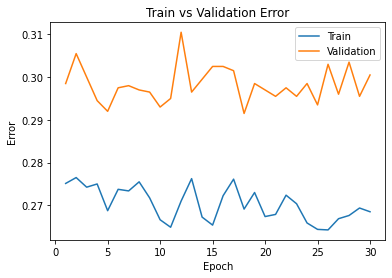

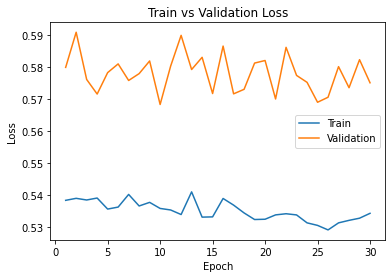

In [ ]:
# small
model_small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_small_path)

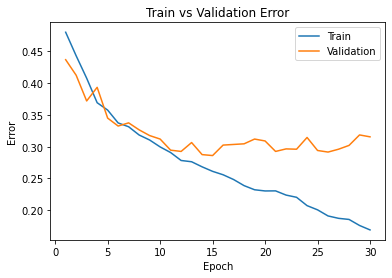

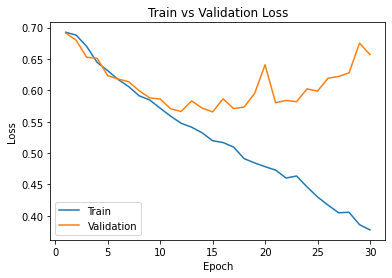

In [ ]:
# large
model_large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# for small_net, both the training error and loss curve appear to be relatively constant (but still decreasing) 
# with little flucturation as the number of epochs increases, because ideally, as we increase the number of iterations, the performance should be 
# more accurate, decreasing the loss and error on the training data.
# for large_net, both the training error and loss curve decrease as the number of epochs increases.

# it is evident that as the number of epochs increases, the validation error and loss begin to increase at some point. 
# especially in the large dataset, at around epoch 15, the validation error and loss curve begin to go up, which shows the overfitting. 
# the model is being trained only to predict the values on the training set, and if it's being trained too well for that task to the point 
# that it loses its ability to generalize to other images.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6947130584716796 |Validation err: 0.509, Validation loss: 0.6943574659526348
Epoch 2: Train err: 0.498, Train loss: 0.6930641102790832 |Validation err: 0.5045, Validation loss: 0.6925353333353996
Epoch 3: Train err: 0.487375, Train loss: 0.6920717873573303 |Validation err: 0.455, Validation loss: 0.6913988310843706
Epoch 4: Train err: 0.465, Train loss: 0.6912757430076599 |Validation err: 0.4315, Validation loss: 0.6899810656905174
Epoch 5: Train err: 0.443875, Train loss: 0.6904333086013794 |Validation err: 0.4245, Validation loss: 0.6890156585723162
Epoch 6: Train err: 0.440625, Train loss: 0.6894718570709228 |Validation err: 0.4225, Validation loss: 0.6873889453709126
Epoch 7: Train err: 0.4395, Train loss: 0.6883323464393616 |Validation err: 0.42, Validation loss: 0.6859681159257889
Epoch 8: Train err: 0.437, Train loss: 0.6870090970993042 |Validation 

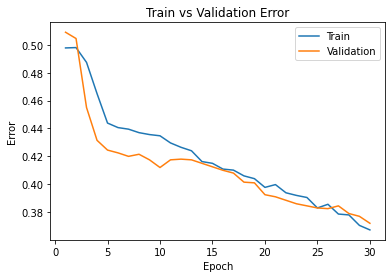

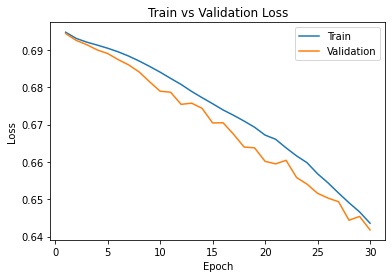

In [12]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
print("The large network took 146.66 seconds to train.")

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

In [ ]:
# After lowering the learning rate, it takes relatively similar amonut of time to train.
# it helped decrease the degree of overfitting to the test set we saw in the earlier model. 
# We can see that the validation loss/error continue to decrease with the training loss/error, and may even be slightly underfitted, 
# as the validation error is higher than the validation error was with default parameters. 
# This is because the parameters take smaller "steps" at each training iteration, so the model doesn't converge as quickly.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

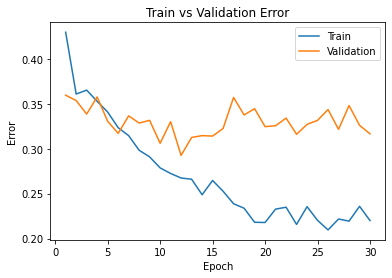

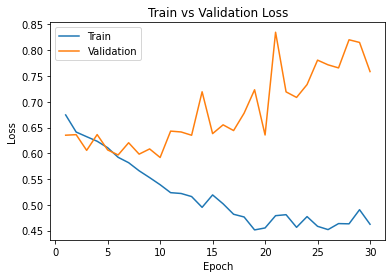

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
print("The large network took 144.41 seconds to train.")

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

In [ ]:
# As we increase the learning rate, it takes relatively similar time to train. 
# However, this clearly caused the model to overfit the training data a lot faster, 
# as we can tell that both the validation loss and error start increasing instead of decreasing after just around 5 epochs of training.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

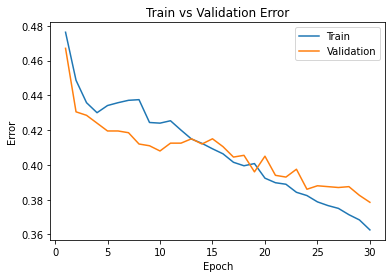

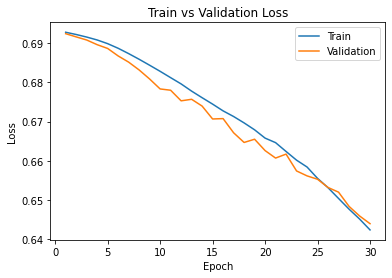

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
print("The large network took 132.87 seconds to train.")

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

In [ ]:
# As we increase the batch size, it decreases the amount of time to train slightly because large batch size means the model is taking
# large gradient steps to update the weights and biases, thus taking less time to go over all the dataset for tuning. 
# As shown in the diagram, as the number of epochs increases, the validation error and loss decrease and might cause underfit.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

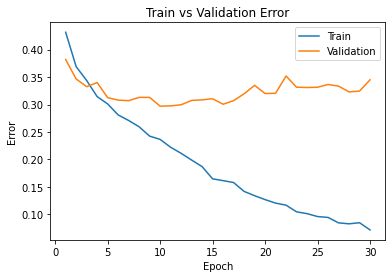

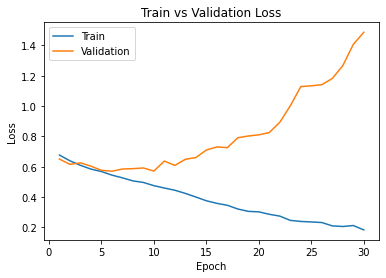

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
print("The large network took 224.12 seconds to train.")

large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

In [ ]:
# Decreasing the batch size increased the training time a lot, to 224.12 seconds, possibly as it means that the model
#  needs to update its weights more often for the same number of epochs. 
# Decreasing the batch size decreased both the validation and training error compared to the previous itration,
# but it is clearly an extremely overfitted model that is unlikely perform well on new data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# as discusses previously, increasing the batch size and decreasing the learning rate will result in higher validation accuracy.
# adding a new hyperparameter, number of epochs, to create a new set of values (network, batch_size = 512, learning_rate = 0.001, epochs = 200)
# as the number of epochs increases, the number of iterations and trainings will increase, thus the model will learn better with higher accuracy.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49725, Train loss: 0.6937627196311951 |Validation err: 0.504, Validation loss: 0.6941862851381302
Epoch 2: Train err: 0.497125, Train loss: 0.6936384402215481 |Validation err: 0.503, Validation loss: 0.6940390467643738
Epoch 3: Train err: 0.496, Train loss: 0.6935578994452953 |Validation err: 0.5015, Validation loss: 0.6939135789871216
Epoch 4: Train err: 0.496875, Train loss: 0.6934670358896255 |Validation err: 0.499, Validation loss: 0.693806529045105
Epoch 5: Train err: 0.49625, Train loss: 0.6933463141322136 |Validation err: 0.5045, Validation loss: 0.6936327517032623
Epoch 6: Train err: 0.4955, Train loss: 0.6932761482894421 |Validation err: 0.505, Validation loss: 0.6935074776411057
Epoch 7: Train err: 0.495, Train loss: 0.6931711584329605 |Validation err: 0.504, Validation loss: 0.6933936476707458
Epoch 8: Train err: 0.498375, Train loss: 0.693088386207819 |Validation err: 0.4985, V

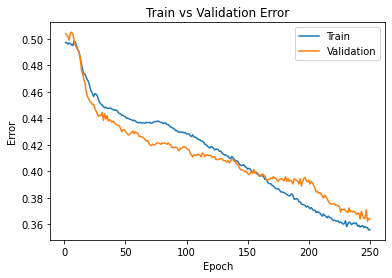

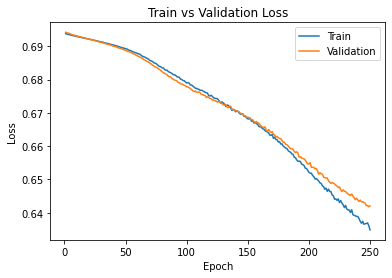

In [15]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001, batch_size = 512, num_epochs = 250)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=249)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# Based on the result from part(a), the model is still underfitting so we should further increase the epoch size to 500.

Files already downloaded and verified
Files already downloaded and verified
The error rate on the test set is 0.5 and the loss on the test set is 0.697258323431015.


### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6935933940112591 |Validation err: 0.491, Validation loss: 0.692963570356369
Epoch 2: Train err: 0.50225, Train loss: 0.6935967020690441 |Validation err: 0.491, Validation loss: 0.6929343789815903
Epoch 3: Train err: 0.50225, Train loss: 0.693499181419611 |Validation err: 0.491, Validation loss: 0.6929014176130295
Epoch 4: Train err: 0.50225, Train loss: 0.6934268996119499 |Validation err: 0.491, Validation loss: 0.692853569984436
Epoch 5: Train err: 0.50225, Train loss: 0.693407204002142 |Validation err: 0.491, Validation loss: 0.6928715407848358
Epoch 6: Train err: 0.50225, Train loss: 0.6933428421616554 |Validation err: 0.491, Validation loss: 0.6928453296422958
Epoch 7: Train err: 0.50225, Train loss: 0.6933229565620422 |Validation err: 0.491, Validation loss: 0.6928307712078094
Epoch 8: Train err: 0.50225, Train loss: 0.6932795085012913 |Validation err: 0.491, Vali

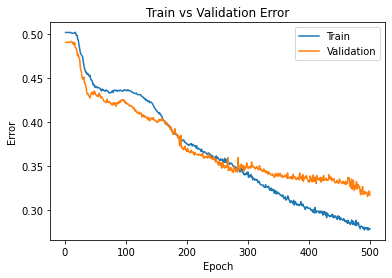

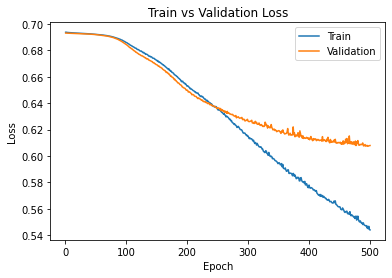

In [16]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.001, num_epochs = 500)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=499)
plot_training_curve(large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [19]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.001, epoch=489)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# I chose the last model I trained as it had the best performance on the validation set without overfitting 
# Though it might take a longer time, but I think the total time spent is reasonable.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [20]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(net, test_loader, criterion)

print("The error rate on the test set is {} and the loss on the test set is {}.".format(testError, testLoss))

Files already downloaded and verified
Files already downloaded and verified
The error rate on the test set is 0.3255 and the loss on the test set is 0.6002155393362045.


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The error rate on test set is 0.3255 whiile the error rate on validation error for my model is 0.312.
# The test error has a higher error rate because validation dataset is more similar to the training set than testing data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# Because we want to use the test data to test our model and see whether it has good accuracy in prediction after training and validating.
# We want to see whether is can correctly model on data that it has not seen before.
# It is important to use as little test data as possible because we don't want the model to also memorize the test data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [21]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = x.squeeze(1)
        return x

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.471625, Train loss: 0.6889894492924213 |Validation err: 0.455, Validation loss: 0.6864063888788223
Epoch 2: Train err: 0.441875, Train loss: 0.6838475205004215 |Validation err: 0.4205, Validation loss: 0.6814091205596924
Epoch 3: Train err: 0.425375, Train loss: 0.6794334687292576 |Validation err: 0.4115, Validation loss: 0.6776512861251831


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fedf0cda8b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 4: Train err: 0.412625, Train loss: 0.6754806451499462 |Validation err: 0.405, Validation loss: 0.6745819300413132
Epoch 5: Train err: 0.40925, Train loss: 0.672142893075943 |Validation err: 0.408, Validation loss: 0.6719444096088409
Epoch 6: Train err: 0.406875, Train loss: 0.6696677729487419 |Validation err: 0.4055, Validation loss: 0.6694786250591278
Epoch 7: Train err: 0.403375, Train loss: 0.6673819124698639 |Validation err: 0.4085, Validation loss: 0.6677323430776596
Epoch 8: Train err: 0.400375, Train loss: 0.6653377041220665 |Validation err: 0.406, Validation loss: 0.6658824235200882
Epoch 9: Train err: 0.39775, Train loss: 0.663564819842577 |Validation err: 0.3995, Validation loss: 0.6642841100692749
Epoch 10: Train err: 0.395625, Train loss: 0.6620236337184906 |Validation err: 0.401, Validation loss: 0.6630454808473587
Epoch 11: Train err: 0.39125, Train loss: 0.6603663675487041 |Validation err: 0.4025, Validation loss: 0.6619492024183273
Epoch 12: Train err: 0.39, Trai

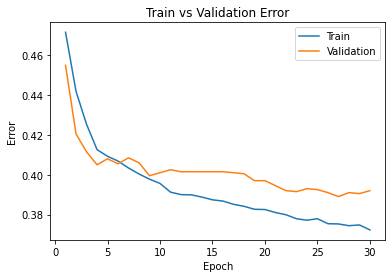

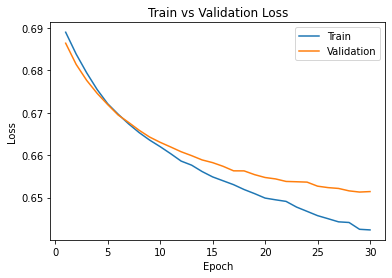

In [23]:
ANN_net = ANN()
train_net(ANN_net, batch_size=512, learning_rate=0.001, num_epochs=30)

ANN_model_path = get_model_name("ANN", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(ANN_model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.443375, Train loss: 0.6823596246540546 |Validation err: 0.4115, Validation loss: 0.6701653003692627
Epoch 2: Train err: 0.40025, Train loss: 0.663324598222971 |Validation err: 0.4005, Validation loss: 0.6594601273536682
Epoch 3: Train err: 0.3875, Train loss: 0.6526675783097744 |Validation err: 0.394, Validation loss: 0.6560882478952408
Epoch 4: Train err: 0.381625, Train loss: 0.6456606797873974 |Validation err: 0.39, Validation loss: 0.6529206782579422
Epoch 5: Train err: 0.369625, Train loss: 0.6394309289753437 |Validation err: 0.3845, Validation loss: 0.6508905589580536
Epoch 6: Train err: 0.3665, Train loss: 0.6355861537158489 |Validation err: 0.393, Validation loss: 0.651695117354393
Epoch 7: Train err: 0.358625, Train loss: 0.6313099749386311 |Validation err: 0.3835, Validation loss: 0.6495392024517059
Epoch 8: Train err: 0.355625, Train loss: 0.6264626979827881 |Validation err: 0.3

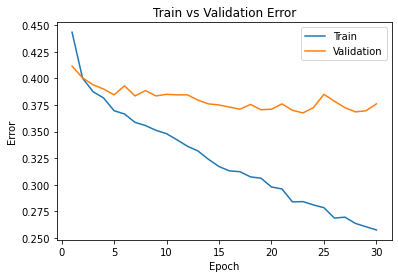

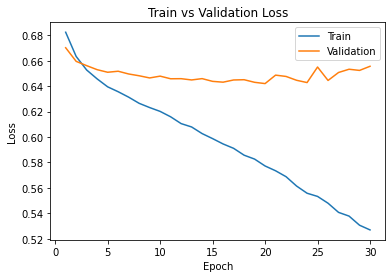

In [24]:
ANN_net = ANN()
train_net(ANN_net, batch_size=512, learning_rate=0.01, num_epochs=30)

ANN_model_path = get_model_name("ANN", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(ANN_model_path)

In [25]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(ANN_net, test_loader, criterion)

print("The error rate on the test set is {} and the loss on the test set is {}.".format(testError, testLoss))

Files already downloaded and verified
Files already downloaded and verified
The error rate on the test set is 0.369 and the loss on the test set is 0.6499877721071243.


In [ ]:
# The ANN network is performing not as well as CNN no matter which hyperparameters I use.